### This notebook works with dog-project conda env that is installed with 

https://github.com/parksoy/Soyoung_Udacity_ND_DeepLearning/blob/master/3.Convolutional_networks/7_dog-project/requirements/dog-linux-gpu.yml

in AWS, deep learning AMI with source code, ubuntu, CUDA8. N. Virginia server was chosen.

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# Check for a GPU
import tensorflow as tf
print(tf.test.gpu_device_name())

/gpu:0


In [2]:
%%bash
pwd

/home/ubuntu/Soyoung_Udacity_ND_DeepLearning/5.Generative_Adversarial_Networks/3_face_generation


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = 'data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

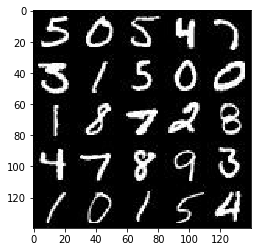

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

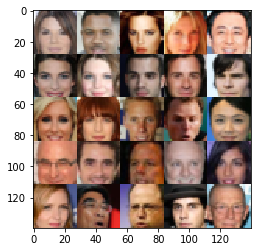

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function    
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32, name='learning_rate')  

    return  inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

### reviewer#1 

#### Discriminator  
1) Leaky ReLU activation function helps with the gradient flow and alleviate the problem of sparse gradients (almost 0 gradients). Max pooling generates sparse gradients, which affects the stability of GAN training. That’s the reason, you chose not to use pooling.

2) You have used batch normalization to stabilize GAN training by reducing internal covariant shift. You can go to this link[http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html] for further understanding Batch norm.

3) You have used Sigmoid as the activation function for the output layer which produces probability-like values between 0 and 1.

Improvement to make:
<font color='red'>
1) Use custom weight initialization. For example Xavier weight initialization to help converge faster by breaking symmetry or you can also use truncated_normal_initializer with stddev=0.02, which improve overall generated image quality, like in DCGAN paper.  

2) Experiment with various values of alpha (slope of the leaky Relu as stated in DCGAN paper) between 0.06 and 0.18 and compare your results.  
 
3) Experiment with dropout layers for discriminator, applying dropout will decrease hyper learning distrib. If discriminator end up dominating generator, we must reduce discriminator learning rate and increase dropout.   
</font>  


Ref: F. Chollet, "Deep Learning with Python" chapt 8.32".   

Use: 

```
dp_layer = tf.nn.dropout(l_relu_output, keep_prob =0.8) or 
dp_layer = tf.layer.dropout(l_relu_output, rate =0.2)
```

In [8]:
#https://discussions.udacity.com/t/discriminator-variable-scope-reuse/662468

depth = 64 #==filters=the dimensionality of the output space(i.e. the number of filters in the convolution).
kernel_size=5 # kernel_size=height and width of the 2D convolution window
strides=2
alpha=0.06 #if this is not within this variable_scope, can not pass test: assert mock_variable_scope.call_args == mock.call('discriminator', reuse=True)
#tf.variable_scope called with wrong arguments in Discriminator Inference(reuse=True)
#Reviewer#1: Experiment with various values of alpha (slope of the leaky Relu as stated in DCGAN paper) between 0.06 and 0.18 and compare your results.
        
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse) :
        
       
        # Hidden layer #1: Input layer is 28x28x3
        h1 = tf.layers.conv2d(images, filters=depth, kernel_size = kernel_size, strides=strides, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * h1, h1)
        relu1_dropout = tf.nn.dropout(relu1, keep_prob =0.8)
        # 14x14x64 now
        
        # Hidden layer #2: 
        h2 = tf.layers.conv2d(relu1_dropout, filters=depth*2, kernel_size = kernel_size, strides=strides, padding='same',\
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2_dropout = tf.nn.dropout(relu2, keep_prob =0.8)
        # 7x7x128 now
        
        # Hidden layer #3: 
        h3 = tf.layers.conv2d(relu2, filters=depth*4, kernel_size = kernel_size, strides=strides, padding='same',\
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(h3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3_dropout = tf.nn.dropout(relu3, keep_prob =0.8)
        # 3x3x256 now

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*depth*4))
        logits = tf.layers.dense(flat, 1)
        isFakeReal = tf.nn.sigmoid(logits)
        
        return isFakeReal, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

### Reviewer#1

#### Generator  

You have used Tanh as the last layer of the generator output, so you will normalize the input images to be between -1 and 1 in train function.

You have met the basic requirements, but I recommend you to work on the below tips and comment on the improvements you see in the generated image.

<font color='red'>  
    
1) Experiment with more conv2d_transpose layers in generator block so that there're enough parameters in the network to learn the concepts of the input images. **DCGAN models produce better results when generator is bigger than discriminator.**  

Suggestion: 1024->512->256->128->out_channel_dim (Use stride as 1 to increase the number of layers without changing the size of the output image).   ==> instead, first input depth is increased from 1024 to 2048

2) Experiment with different slope values for leaky_relu as told in discriminator.  

3) Experiment dropout in generator, so that it is less prone to learning the data distribution and avoid generating images that look like noise.   

(CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC)  
</font>

In [9]:
import math
z=100
int(math.sqrt(z))

10

In [10]:

reshape_d=5


def generator(z, out_channel_dim,  is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        #Using the reverse process of the discriminator
        
        # First fully connected layer #1:
        h1 = tf.layers.dense(z, reshape_d*reshape_d*1024) # First fully connected layer, 256
        #(?, 256) now
        
        #Input to reshape is a tensor with z*56 values, but the requested shape requires a multiple of reshape_d**2 * 1024
        #Input to reshape is a tensor with 8192 values, but the requested shape requires a multiple of 25600
        
        print("z=", z)
        
        h1 = tf.reshape(h1, (-1, reshape_d, reshape_d, 1024))  #this 1024 is my choice upon paper. reshape_d comes from     
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        h1_dropout = tf.nn.dropout(h1, keep_prob =0.8)
        #(?, 7,7,1024) now
        
        # Hidden layer #2:
        h2 = tf.layers.conv2d_transpose(h1_dropout, 512, kernel_size = kernel_size, \
                                        strides=2, padding='same', \
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("h2 (?, , , 512)=", h2.get_shape()) 
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2_dropout = tf.nn.dropout(h2, keep_prob =0.8)
        #(?, 7, 7, 512)    
        
        # Hidden layer #3:
        h3 = tf.layers.conv2d_transpose(h2_dropout, 256, kernel_size = kernel_size, \
                                        strides=2, padding='same', \
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("h3 (?, , , 256)=", h3.get_shape()) #
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3_dropout = tf.nn.dropout(h3, keep_prob =0.8)
        #(?, 7, 7, 256)
        
        # Hidden layer #4:
        h4 = tf.layers.conv2d_transpose(h3_dropout, 128, kernel_size = kernel_size, \
                                        strides=1, padding='valid',\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("h4 (?, , , 128)=", h4.get_shape()) 
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = tf.maximum(alpha * h4, h4)
        h4_dropout = tf.nn.dropout(h4, keep_prob =0.8)
        #(?, 14, 14, 128)
        

        #final layer #5:
        logits = tf.layers.conv2d_transpose(h4_dropout, out_channel_dim, kernel_size = kernel_size, \
                                            strides=1, padding='valid',\
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("out_channel_dim=",out_channel_dim)
        print("logits (?, 28, 28, 5) =", logits.get_shape()) 
        fake_image = tf.tanh(logits)
        #(?, 28, 28, 5)
        
    return fake_image

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

z= Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 5
logits (?, 28, 28, 5) = (?, 28, 28, 5)
z= Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 5
logits (?, 28, 28, 5) = (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

### Reviewer #1

<font color='red'>    
Experiment with label smoothing for discriminator loss, it prevents discriminator from being too strong and to   generalize in a better way.    
</font>
Refer https://arxiv.org/abs/1606.03498

Below is a starter code,   
 
```python
d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
```

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Initializing Variables with predictions
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the Losses for it real, fake & generated models
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # The Discriminator Loss is the amount of it fake img loss + it real img loss
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

z= Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 4
logits (?, 28, 28, 5) = (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

### Reviewer #1 

<font color='red'>    
To avoid internal covariant shift during training, you use batch norm. But in tensorflow **when is_train is true and you have used batch norm, mean and variance needs to be updated before optimization**. So, you add control dependency on the update ops before optimizing the network.   
</font>  

    More Info here 

http://ruishu.io/2016/12/27/batchnorm/

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Empty TF TrainableVariables
    t_vars = tf.trainable_variables()
    
    # Append var to D & G vars arraies if it starts with the "prefix" for on it name
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimization
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    # UPDATE OPS GraphKeys
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

### Reviewer #1

Great work combining all the functions together and making it a DCGAN.

Good job scaling the input images to the same scale as the generated ones using batch_images *= 2.0 .

Tip:   
  
**Execute the optimization for generator twice. This ensures that the discriminator loss does not go to 0 and impede learning.**  

Extra:  
1) Talk on “How to train a GAN” by one of the author of original DCGAN paper here..https://www.youtube.com/watch?v=X1mUN6dD8uE

2) Here is a post on Gan hacks, https://github.com/soumith/ganhacks  

<font color='red'>
3) Plot discriminator and generator loss for better understanding. You can utilize the below code snippet to plot the loss graph to get a better understanding.
</font>

```
d,_ = sess.run(…)
g,_ = sess.run(…)
d_loss_vec.append(d)
g_loss_vec.append(g)
```

At the end, you can include the below code to plot the final array:

```
Discriminator_loss, = plt.plot(d_loss_vec, color='b', label='Discriminator loss')
Genereator_loss, = plt.plot(g_loss_vec, color='r', label='Generator loss')
plt.legend(handles=[ Discriminator_loss, Genereator_loss])
```


In [14]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epochs: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape # 28x28x3 or 28x28x1
    real_input_img, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input_img, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    samples, losses = [], []
    n_images = 25        
    print_every = 20
    show_every = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1 
                batch_images *= 2.0 
                
                # Sample random "noise vector" for generator
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim)) 
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input_img: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # Showing the generator image output for every = show_every step
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

### Reviewer #1

The hyperparameters chosen are correct. You can further improve the quality of the generated image by experimenting with the parameters and the tips I provided in discriminator, generator and model loss. Below are a few extra tips on choosing the hyperparameters for starters...

Tips: 
1) Try using different values of learning rate between 0.0002 and 0.0008, this DCGAN architectural structure remains stable within that range.

2) Experiment with different values of beta1 between 0.2 and 0.5 and compare your results. Here's a good post explaining the importance of beta values and which value might be empirically better. http://ruder.io/optimizing-gradient-descent/index.html#adam.

3) An important point to note is, batch size and learning rate are linked. If the batch size is too small then the gradients will become more unstable and would need to reduce the learning rate and vice versa. Start point for experimenting on batch size would be somewhere between 16 to 32.

Extra: You can also go through Population based training of neural networks, https://deepmind.com/blog/population-based-training-neural-networks/ it is a new method for training neural networks which allows an experimenter to quickly choose the best set of hyperparameters and model for the task.



z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 2.6247... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 1.6566
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 1.1986
Epoch 1/2... Discriminator Loss: 1.8843... Generator Loss: 1.3395
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 2.0923
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


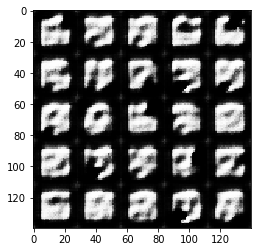

Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 1.6417
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.8971
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 1.0932
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 0.7367
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


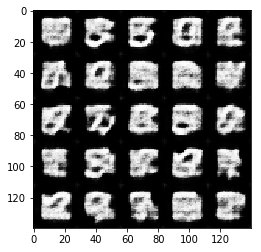

Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 1.2632
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 1.8258
Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 1.8505
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


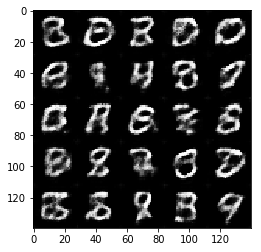

Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 1.2688
Epoch 1/2... Discriminator Loss: 1.7255... Generator Loss: 0.3174
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 1.6831
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 1.1979
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


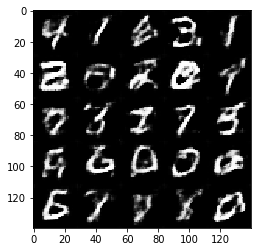

Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 1.6437
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.2858... Generator Loss: 1.3177
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.6302
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


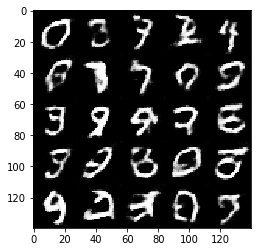

Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.5398
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 1.1518
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.0724... Generator Loss: 0.8024
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


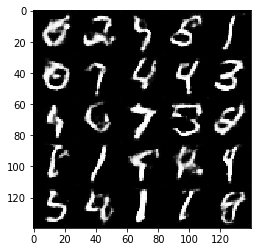

Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 0.9649
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.4800
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 0.8370
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


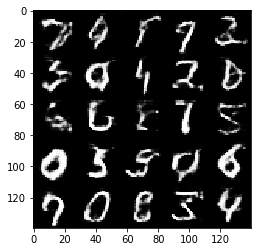

Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.5592
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.3883
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.7131
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


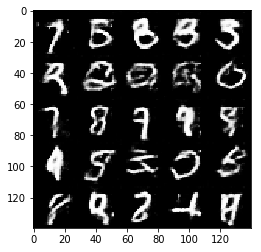

Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.8325
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.8193
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


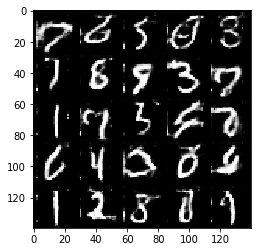

Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.8543
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 0.9481... Generator Loss: 1.3600
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.5850
Epoch 1/2... Discriminator Loss: 0.9450... Generator Loss: 1.0417
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


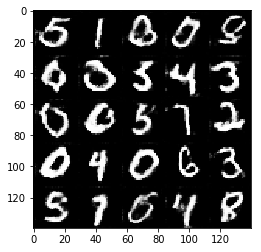

Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 1.4526
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 1.1242
Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 1.3328
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


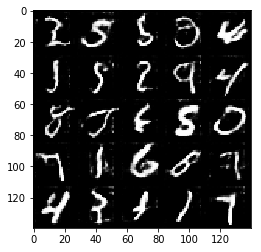

Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 0.9465
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.2008... Generator Loss: 0.8558
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


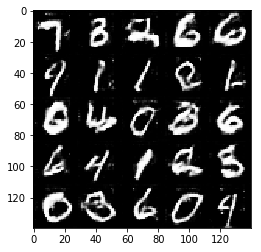

Epoch 1/2... Discriminator Loss: 0.9771... Generator Loss: 1.0694
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 0.9731
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


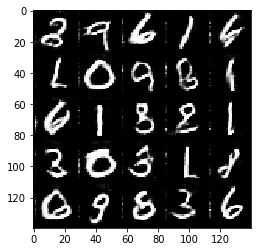

Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 0.3566
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.7521
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


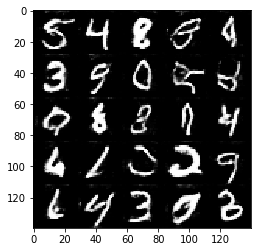

Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 1.0080
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 1.3297
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 1.0800
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 0.6569
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


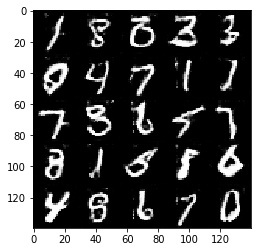

Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 0.9502
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.5041
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 1.2267
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 1.0053
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


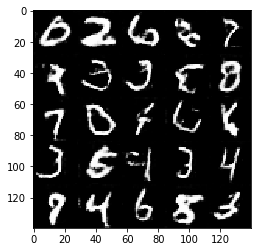

Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 0.9133
Epoch 1/2... Discriminator Loss: 0.7895... Generator Loss: 1.2212
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.3070
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


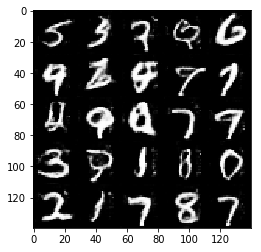

Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.5932
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 0.9906... Generator Loss: 1.2214
Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 0.9997
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


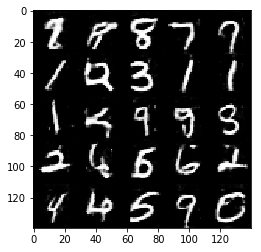

Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.5277
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 1.1906
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 1.4988... Generator Loss: 0.4414
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


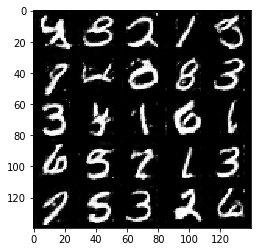

Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 1.6341
Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 0.9821
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.2488
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.3356
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


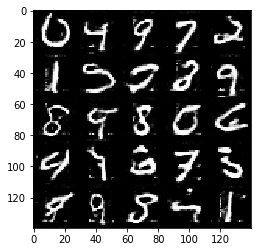

Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.2228
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.4987
Epoch 2/2... Discriminator Loss: 1.0115... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.6590
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


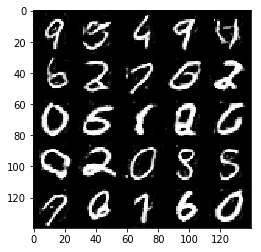

Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 1.4918
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.1593
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 1.1082
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


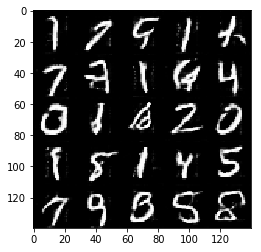

Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 1.2359
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.5432
Epoch 2/2... Discriminator Loss: 1.5066... Generator Loss: 0.4207
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 0.9620
Epoch 2/2... Discriminator Loss: 0.9999... Generator Loss: 0.7765
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


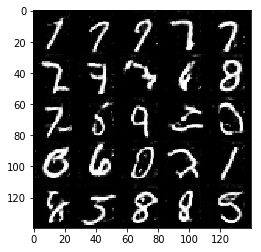

Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.7351
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 1.0361... Generator Loss: 0.8561
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 0.8916... Generator Loss: 0.8937
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


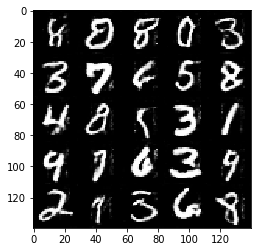

Epoch 2/2... Discriminator Loss: 0.7057... Generator Loss: 1.3204
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 0.9962
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.3252
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 0.4766
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


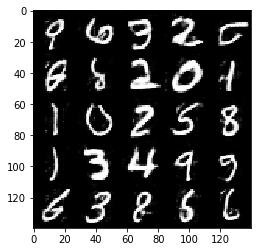

Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.8575
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 0.9382
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.0100
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


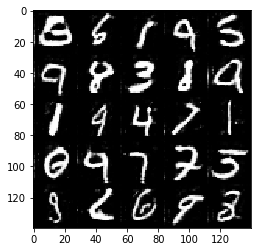

Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 1.1874
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.1008
Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.0080
Epoch 2/2... Discriminator Loss: 0.9011... Generator Loss: 1.0589
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


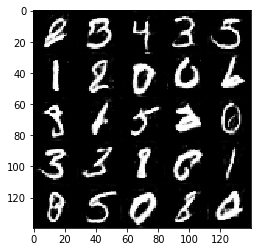

Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 1.3336
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 0.5446
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


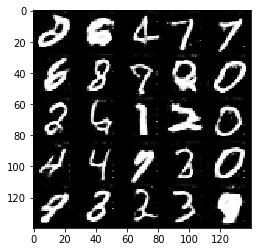

Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 1.4697
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.0496
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


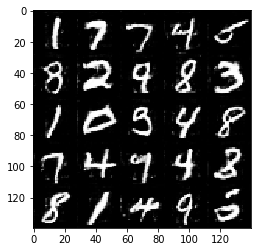

Epoch 2/2... Discriminator Loss: 0.7468... Generator Loss: 1.6121
Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 1.6585
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 0.5307
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 0.8055
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


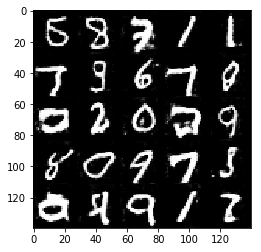

Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 1.2441
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.5735
Epoch 2/2... Discriminator Loss: 0.8416... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 1.1491
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.9464
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


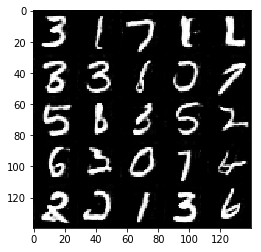

Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 1.2226
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 1.3016
Epoch 2/2... Discriminator Loss: 0.6749... Generator Loss: 1.4645
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 1.0350
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


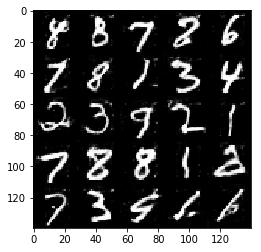

Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.2137
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.1887
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 1.1442
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


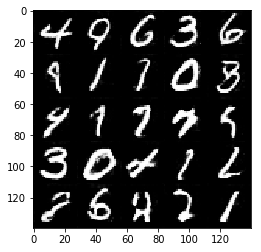

Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.7558
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.3309
Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 1.3025
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.1509
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 1.4709
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


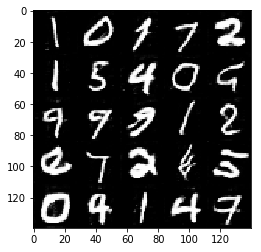

Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 1.3888
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 0.6213
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.4193
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


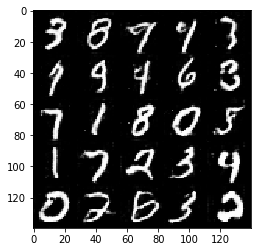

Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.6490
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.0474
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 1.0188
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


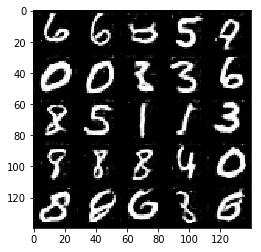

Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 1.8997
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 1.7921
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 1
logits (?, 28, 28, 5) = (?, 28, 28, 1)


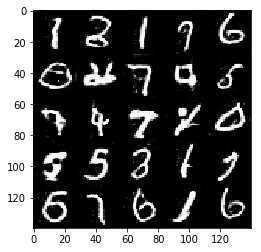

Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.1452
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.4714


In [15]:
batch_size = 32 # Reviewer#1 Start point for experimenting on batch size would be somewhere between 16 to 32.
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5 # AdamOptimizer. Reviewer#1: Experiment with different values of beta1 between 0.2 and 0.5 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [ ]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
mnist_dataset.shape

(60000, 28, 28, 1)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

### Reviewer #1

<font color='red'>  
If you want to generate varied face shapes, experiment with the value of z_dim (probably in the range 128 - 256).  
</font>  

z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.0511... Generator Loss: 3.7497
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 8.5884
Epoch 1/1... Discriminator Loss: 0.2988... Generator Loss: 2.6099
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 1.7914
Epoch 1/1... Discriminator Loss: 2.2930... Generator Loss: 0.2209
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


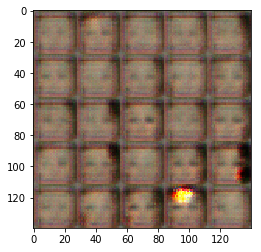

Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 2.0318... Generator Loss: 0.2350
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.1757
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


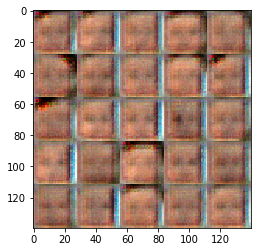

Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 2.6207
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 0.2770... Generator Loss: 1.9999
Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 2.6044
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.4919
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


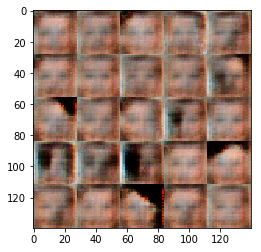

Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 3.6520
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 0.9346
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


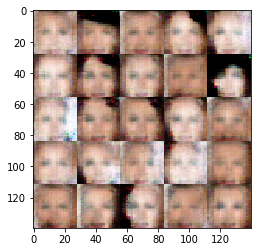

Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.6682
Epoch 1/1... Discriminator Loss: 2.2928... Generator Loss: 0.2361
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.5554
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


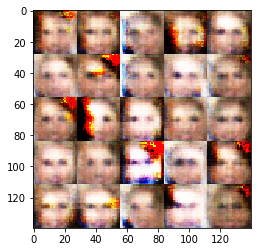

Epoch 1/1... Discriminator Loss: 2.6890... Generator Loss: 2.5866
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 1.7185... Generator Loss: 0.3018
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.1146
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


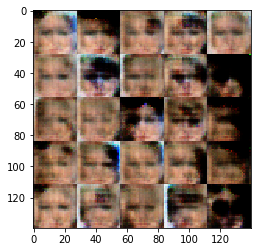

Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 1.6757
Epoch 1/1... Discriminator Loss: 2.8459... Generator Loss: 0.1231
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 0.9187
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


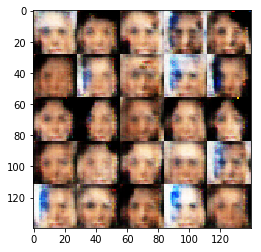

Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 2.0154... Generator Loss: 4.1142
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.3618
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


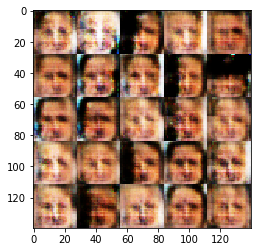

Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.1626
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


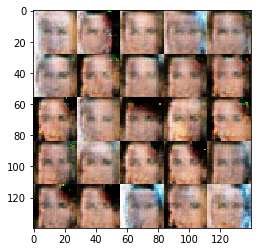

Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 2.0654
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 1.9344
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.6478
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


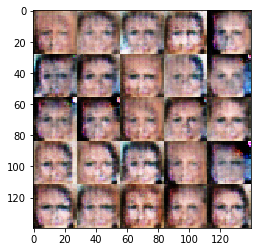

Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.8488... Generator Loss: 0.3077
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


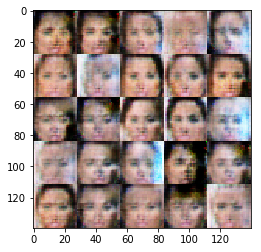

Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.0600
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


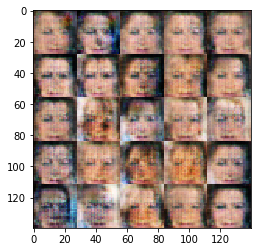

Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.3152
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.3464
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


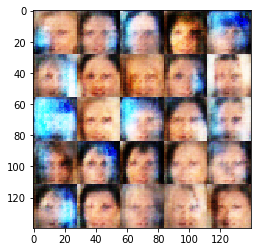

Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 1.8943
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 1.0175
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


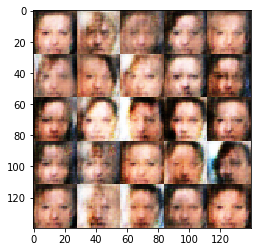

Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.3419
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.5912
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


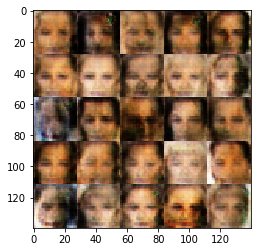

Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.2947
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.9695
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.0048
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


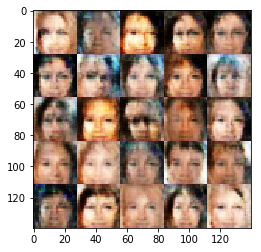

Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.8614
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


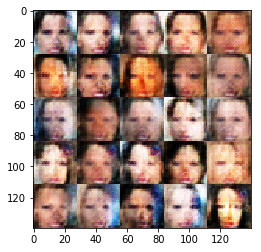

Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.6572... Generator Loss: 0.4622
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


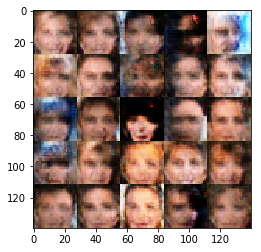

Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.5451
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


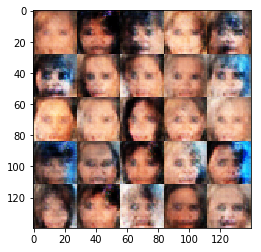

Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7501
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


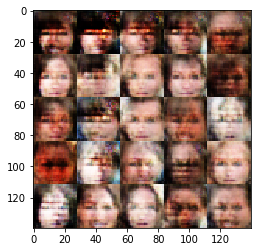

Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7553
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


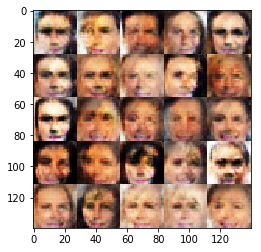

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.6563
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


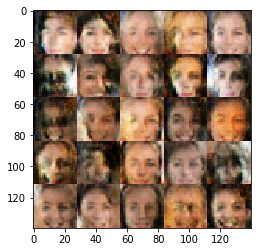

Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.4140
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


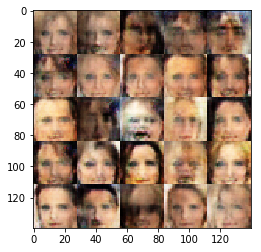

Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.7061... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.8490
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


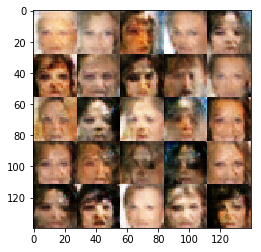

Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.3722
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


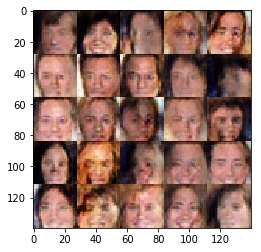

Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.7892
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


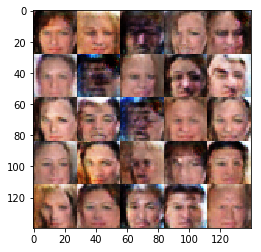

Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8748
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


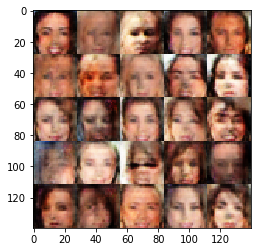

Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.2756
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


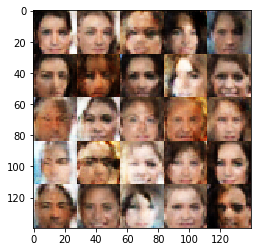

Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.4793
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


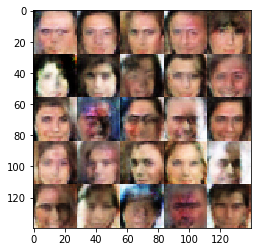

Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.6086
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


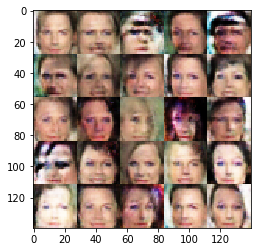

Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 0.6624
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


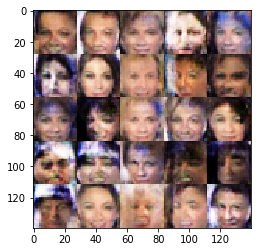

Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.8111
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6815
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


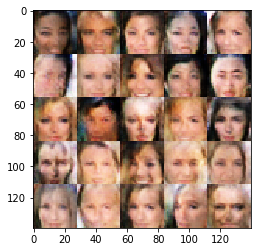

Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.4195
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.4058
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


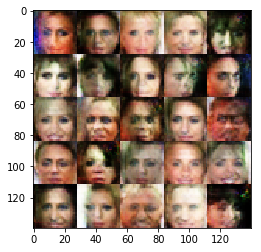

Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.2653
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


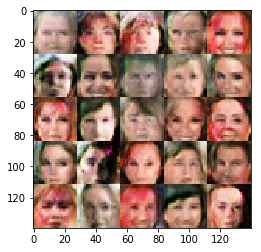

Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.7878
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


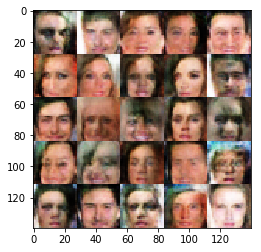

Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.4092
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.4812
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.6053
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


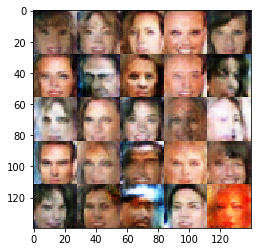

Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.3446
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.0392
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


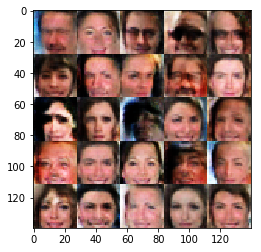

Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.3168
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


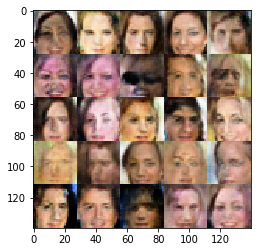

Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.5876
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


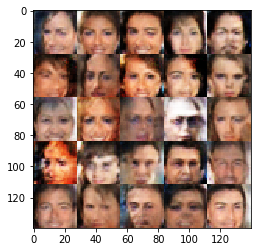

Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6823
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


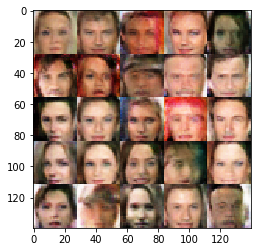

Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6553
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


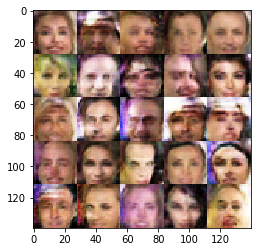

Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.8701
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


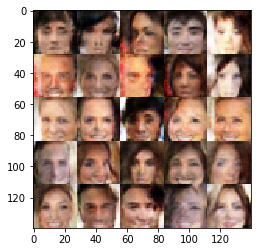

Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 2.0752... Generator Loss: 0.1977
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


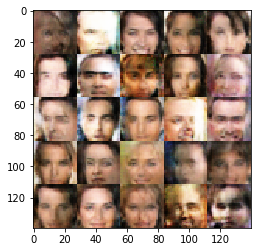

Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.3778
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6663
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


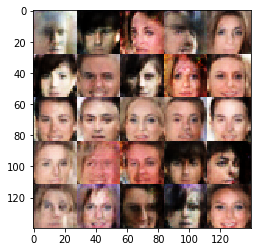

Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.6159
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


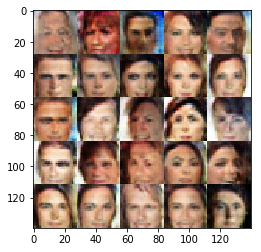

Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.7355
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


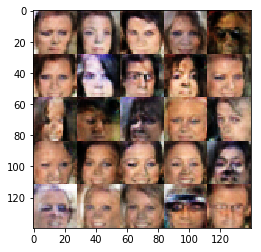

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.1344
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


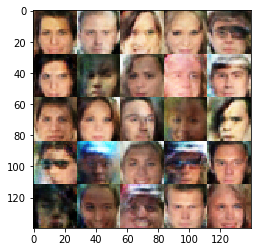

Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8734
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


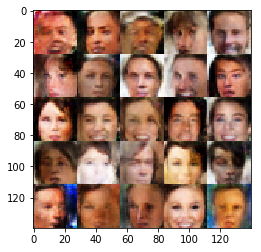

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.4602
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


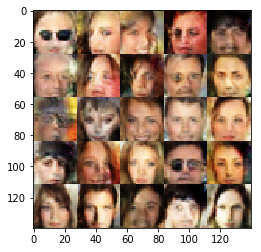

Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8426
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


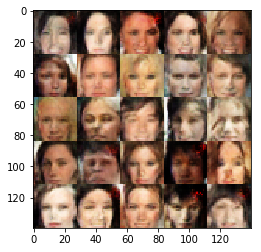

Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 1.3121
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


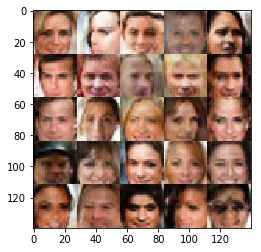

Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.1463
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.8451
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


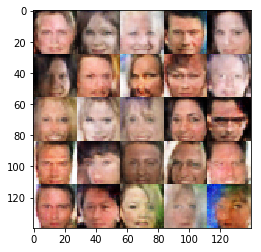

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.0264
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


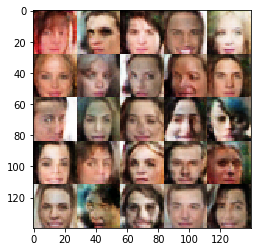

Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.5260
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.1164
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


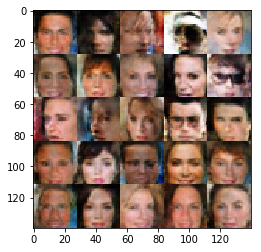

Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9507
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


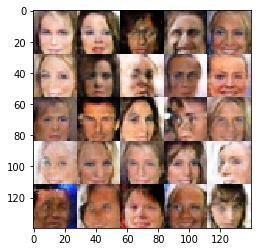

Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.2264
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.1944
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


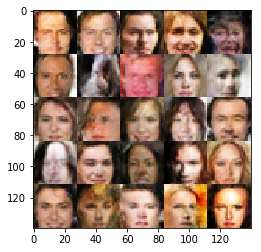

Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.1421
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


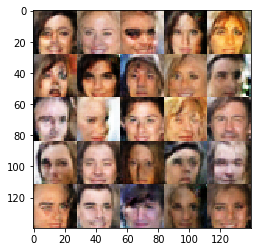

Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7305
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


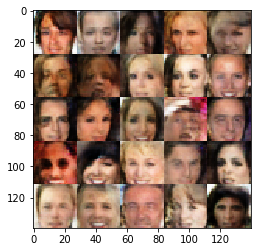

Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 1.5442
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 1.1552
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


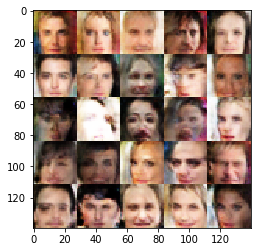

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.9319
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


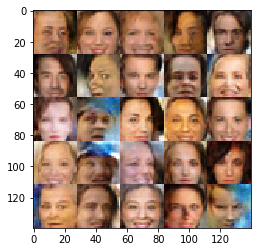

Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.8091
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


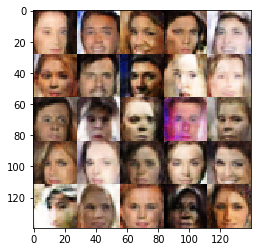

Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.5828
z= Tensor("input_z:0", shape=(?, 128), dtype=float32)
h2 (?, , , 512)= (?, 10, 10, 512)
h3 (?, , , 256)= (?, 20, 20, 256)
h4 (?, , , 128)= (?, 24, 24, 128)
out_channel_dim= 3
logits (?, 28, 28, 5) = (?, 28, 28, 3)


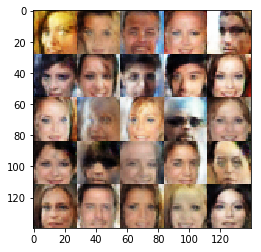

Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.8463


In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
celeba_dataset.shape

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.